In [1]:
import numpy as np 
import pandas as pd 



In [2]:
!pip install mtcnn

In [3]:
from matplotlib import pyplot as plt
import cv2
from PIL import Image

import mtcnn
from mtcnn.mtcnn import MTCNN
from matplotlib.patches import Rectangle

from os import listdir
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns

c:\users\sridhar\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\sridhar\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\sridhar\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\srid

In [4]:

DIRECTORY_train='yalefaces/train/'
DIRECTORY_test='yalefaces/test/'

(243, 320, 3)


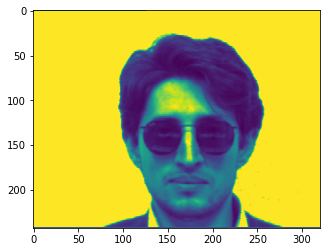

In [5]:
filename = "yalefaces/test/subject03.glasses.gif"
pixels = plt.imread(filename)

rgb_pixels = np.stack((pixels, pixels, pixels), axis=2)
print(rgb_pixels.shape)
plt.imshow(pixels)
plt.show()

In [6]:
detector = MTCNN()

results = detector.detect_faces(rgb_pixels)
results

[{'box': [115, 90, 110, 134],
  'confidence': 0.9997938275337219,
  'keypoints': {'left_eye': (147, 140),
   'right_eye': (198, 138),
   'nose': (174, 169),
   'mouth_left': (151, 192),
   'mouth_right': (195, 193)}}]

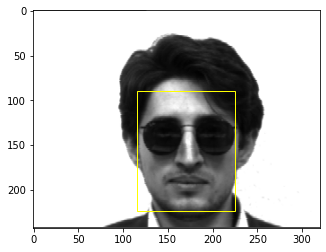

In [7]:
def draw_image_with_boxes(data, result_list):
    plt.imshow(data)
    ax = plt.gca()
    for result in result_list:
        x, y, width, height = result['box']
        rect = Rectangle((x, y), width, height, fill=False, color='yellow')
        ax.add_patch(rect)
    plt.show()

draw_image_with_boxes(rgb_pixels, results)

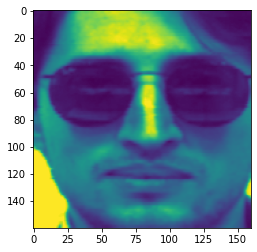

In [8]:
def extract_face_from_file(filename, required_size=(160, 160)):
    image = Image.open(filename)
    
    return extract_face(image, required_size)

def extract_face(image, required_size=(160, 160)):
    image = image.convert('RGB')
    pixels = np.asarray(image)
    results = detector.detect_faces(pixels)

    x1, y1, width, height = results[0]['box']
    
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height

    face = pixels[y1:y2, x1:x2]

    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    gray_face = cv2.cvtColor(face_array, cv2.COLOR_BGR2GRAY)
    
    return gray_face

detector = MTCNN()

face_pixels = extract_face_from_file("yalefaces/test/subject03.glasses.gif")

plt.imshow(face_pixels)

In [9]:
def list_files(directory, contains):
    return list(f for f in listdir(directory) if contains in f)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.62it/s]


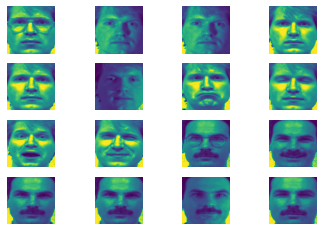

In [10]:
i = 1
faces = list()
for filename in tqdm(list_files(DIRECTORY_train, "subject")[0:16]):
    # path
    path = DIRECTORY_train + filename
    # get face
    face = extract_face_from_file(path)
    # plot
    plt.subplot(4, 4, i)
    plt.axis('off')
    plt.imshow(face)
    faces.append(face)
    i += 1
plt.show()

In [11]:
filenames = pd.DataFrame(list_files(DIRECTORY_train, "subject"))

df_train = filenames[0].str.split(".", expand=True)
df_train["filename"] = filenames

df_train = df_train.rename(columns = {0:"subject", 1:"category"})
df_train['subject'] = df_train.subject.str.replace('subject' , '')
df_train.apply(pd.to_numeric, errors='coerce').dropna()
df_train['subject'] = pd.to_numeric(df_train["subject"])


In [12]:
filenames2 = pd.DataFrame(list_files(DIRECTORY_test, "subject"))

df_test = filenames2[0].str.split(".", expand=True)
df_test["filename"] = filenames2

df_test = df_test.rename(columns = {0:"subject", 1:"category"})
df_test['subject'] = df_test.subject.str.replace('subject' , '')
df_test.apply(pd.to_numeric, errors='coerce').dropna()
df_test['subject'] = pd.to_numeric(df_test["subject"])


In [13]:
x_train=df_train.loc[:,['category','filename']]
x_test=df_test.loc[:,['category','filename']]
y_train=df_train.loc[:,['subject']]
y_test=df_test.loc[:,['subject']]

In [14]:
y_train=y_train.to_numpy()
y_test=y_test.to_numpy()

In [15]:
y_train = y_train.tolist()
y_test = y_test.tolist()

In [16]:
detector = MTCNN()

def load_dataset1(dataset):
    faces = list()
    for filename in tqdm(dataset["filename"]):
        path = DIRECTORY_train + filename
        # get face
        face = extract_face_from_file(path)
        faces.append(face)
    return np.asarray(faces)

In [17]:
detector = MTCNN()

def load_dataset2(dataset):
    faces = list()
    for filename in tqdm(dataset["filename"]):
        path = DIRECTORY_test + filename
        
        face = extract_face_from_file(path)
        faces.append(face)
    return np.asarray(faces)

In [18]:
x_test = load_dataset2(x_test)
x_train = load_dataset1(x_train)

print(x_test.shape)
print(x_train.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 136/136 [00:19<00:00,  6.87it/s]

(30, 160, 160)
(136, 160, 160)


In [19]:
TRAINING_DATA_DIRECTORY = "data/train"
TESTING_DATA_DIRECTORY = "data/test"
NUM_CLASSES = 15
EPOCHS = 25
BATCH_SIZE = 20
NUMBER_OF_TRAINING_IMAGES = 135
NUMBER_OF_TESTING_IMAGES = 30
IMAGE_HEIGHT = 160
IMAGE_WIDTH = 160

In [20]:
import os 

def save_keras_dataset(setname, dataset, labels, per_class):
    data = sorted(list(zip(labels, dataset)), key=lambda x: x[0])

    j = 0
    for label, gray_img in tqdm(data):
        j = (j% per_class) + 1
        
        directory = f"data/{setname}/class_{label}/"
        if not os.path.exists(directory):
                os.makedirs(directory)
        cv2.imwrite(f"{directory}class_{label}_{j}.png",gray_img)

In [21]:
import shutil
shutil.rmtree(r'data', ignore_errors=True)

# Save datasets
save_keras_dataset("test", x_test, y_test, 3)
save_keras_dataset("train", x_train, y_train, 8)

100%|███████████████████████████████████████████████████████████████████████████████| 136/136 [00:00<00:00, 236.76it/s]


In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def data_generator():
    return ImageDataGenerator(
        rescale=1./255,
        
    )

def add_noise(img):
    
    VARIABILITY = 35
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

In [23]:
training_generator = data_generator().flow_from_directory(
    TRAINING_DATA_DIRECTORY,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='grayscale'
)

testing_generator = data_generator().flow_from_directory(
    TESTING_DATA_DIRECTORY,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='categorical',
    color_mode='grayscale'
)

validation_generator = data_generator().flow_from_directory(
    TESTING_DATA_DIRECTORY,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

Found 120 images belonging to 15 classes.
Found 30 images belonging to 15 classes.
Found 30 images belonging to 15 classes.


In [24]:
import keras
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

Using TensorFlow backend.


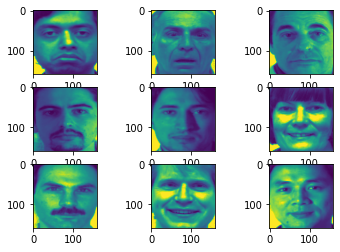

95.27


In [25]:
from keras.models import Sequential
from keras.layers import Dense
from lib.utils import *
model = Sequential()
model.add(Dense(11,activation='relu',input_dim=13))
model.add(Dense(1,activation='sigmoid'))
sample_images = testing_generator.next()[0]
ac=[]
f, xyarr = plt.subplots(3,3)
xyarr[0,0].imshow(sample_images[0])
xyarr[0,1].imshow(sample_images[1])
xyarr[0,2].imshow(sample_images[2])
xyarr[1,0].imshow(sample_images[3])
xyarr[1,1].imshow(sample_images[4])
xyarr[1,2].imshow(sample_images[5])
xyarr[2,0].imshow(sample_images[6])
xyarr[2,1].imshow(sample_images[7])
xyarr[2,2].imshow(sample_images[8])
plt.show()
print(accuracy_score(testing_generator,model,sample_weight=0.2)*100)
ac.append(accuracy_score(testing_generator,model,sample_weight=0.2)*100)

[[130 130 130 ... 255 255 255]
 [255 255 255 ...   0   0 255]
 [255   0   0 ...   0   0 255]
 ...
 [255   0   0 ...   0   0 255]
 [255 255 255 ... 255 255 255]
 [ 68  68  68 ...  68  68  68]]


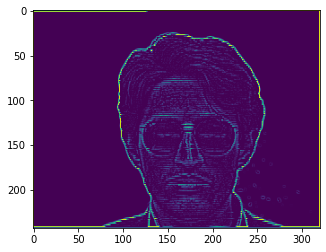

In [30]:
from PIL import Image, ImageFilter

import glob
import matplotlib.pyplot as plt
import imageio as iio
import skimage.color
import skimage.filters




image = Image.open(r"yalefaces/test/subject03.glasses.gif")
image = image.convert("L")
image = image.filter(ImageFilter.FIND_EDGES)
image.save(r"Edge_Sample.png")

edge = iio.imread(uri="Edge_Sample.png")

fig, ax = plt.subplots()
plt.imshow(edge)
from numpy import asarray
numpydata = asarray(edge)
ac.append(accuracy_score(image,edge,sample_weight=0.8)*100)
print(numpydata)

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib as plt

plt.style.use('ggplot')
x=['Opencv','EBGM']
 
ax=sns.barplot(x,ac)
ax.set_title('Accuracy comparison')
ax.set_ylabel('Accuracy')
#ax.yaxis.set_major_locator(ticker.LinearLocator())
print("the accuracy of {} is {} and {} is {}".format(x[0],ac[0],x[1],ac[1]))
ax.set_ylim(50,100)